# TEAMx Recipe Books

# Mapping

Several recipes are provided for making maps of the TEAMx study area. These recipes are meant to be adapted for your own purposes and not used as presented. As a result, many of the maps simply show methods that can be used and are not particularly aesthetic or useful.

## Environment

See `mapping-environment.yml` for the conda environment used for this recipe book.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.srtm import read_SRTM
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import xarray as xr

# Helper functions
sys.path.append('../helpers')
import get_project_path
dir_helpers, dir_project, dir_data = get_project_path.project_paths()


# Directories

In [2]:
# 
dir_data_maps = os.path.join(dir_data, 'maps')

# Figures
dir_print = os.path.join(dir_project, 'figures/')

# Context map

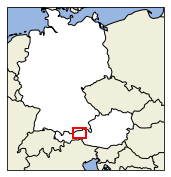

In [3]:
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
fig = plt.figure(figsize=(3, 3))
axins = plt.axes(projection=ccrs.Mercator())
axins.set_extent([5, 20, 45, 55])

for country in countries:
    if country.attributes['ADMIN'] == 'Germany' or country.attributes['ADMIN'] == 'Austria':
        germany = country
        axins.add_geometries(country.geometry, ccrs.PlateCarree(),
                             facecolor=(1, 1, 1),
                             label=country.attributes['ADMIN'])

axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])

axins.add_feature(cfeature.LAND.with_scale('50m'))
axins.add_feature(cfeature.OCEAN.with_scale('50m'))
axins.add_feature(cfeature.COASTLINE.with_scale('50m'))
axins.add_feature(cfeature.BORDERS.with_scale('50m'))

# How to add a point to the map
# axins.plot(12., 47.5, 'ro', markersize=10, transform=ccrs.PlateCarree())

# The TEAMx study area rectangle
maxy = 47.79
miny = 47.13
maxx = 12.5
minx = 11.3
rect = matplotlib.patches.Rectangle(
    xy=(minx, miny), width=maxx - minx, height=maxy - miny,
    transform=ccrs.PlateCarree(), linewidth=2, edgecolor='r', facecolor='none', zorder=10)
axins.add_patch(rect)

# Read and process the hgt DEM

In [4]:
# os.chdir(os.path.join(dir_data_maps, 'srtm_TEAMx_PC22'))
os.chdir(dir_data_maps)

filename_left_srtm = 'N47E011.hgt'
filename_right_srtm = 'N47E012.hgt'

In [5]:
def get_bounding(locs, elevs,
                 maxy=47.9, miny=47.13, maxx=12.5, minx=11.3):
    
    # [latmin, latmax, lonmin, lonmax] = locs
    [lonmin, lonmax, latmin, latmax] = locs

    lats = np.linspace(latmin, latmax, 3601)
    lons = np.linspace(lonmin, lonmax, 3601)

    xind = np.nonzero((lons > minx) & (lons < maxx))
    yind = np.nonzero((lats > miny) & (lats < maxy))

    lats_sub = lats[yind]
    lons_sub = lons[xind]
    elev_sub = elevs[np.min(yind):np.max(yind) + 1, np.min(xind):np.max(xind) + 1]
    
    return elev_sub, lats_sub, lons_sub

In [6]:
def locate_site_index(sitex, sitey, lons, lats):
    """Returns the index of a point in the lat and lon variables.
    
    Example:
    # The Kolsaas site
    sitex = 11.62219
    sitey = 47.305341
    
    k_ind_lon, k_ind_lat = locate_site_index(sitex, sitey, lons, lats)
    """
    
    site_ind_x = np.nonzero(np.abs(lons - sitex) == np.min(np.abs(lons - sitex)))
    site_ind_y = np.nonzero(np.abs(lats - sitey) == np.min(np.abs(lats - sitey)))
    
    return site_ind_x, site_ind_y

In [7]:
maxy = 47.79
miny = 47.13
maxx = 12.5
minx = 11.3

os.chdir(dir_data_maps)
left_elev, left_proj, locs = read_SRTM(filename_left_srtm)
left_elev, left_lats, left_lons = get_bounding(locs, left_elev)

right_elev, right_proj, locs = read_SRTM(filename_right_srtm)
right_elev, right_lats, right_lons = get_bounding(locs, right_elev)

# We concatenate longitude so only one lats variable is necessary
lats = left_lats

# Concatenate across all longitudes.
elevs = np.concatenate((left_elev, right_elev), axis=1)
lons = np.concatenate((left_lons, right_lons), axis=0)

Make sure it looks ok:

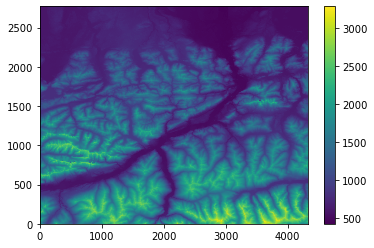

In [8]:
plt.pcolormesh(elevs)
plt.colorbar()

Looks like how I would expect!

Next, make sure that the subset selection process generated consistent variables.

In [9]:
print(np.shape(lats))
print(np.shape(lons))
print(np.shape(elevs))

(2771,)
(4320,)
(2771, 4320)


# Test plotting elements

## Formatting unfilled contours

Formatted for unfilled contour labels (unused in this example but useful if you need it).

In [10]:
class nf(float):
    def __repr__(self):
        s = f'{self:3.0f}'
        return s #f'{self:.0f}' if s[-1] == '0' else s
    
# For formatting contour level labels, you can use this snippet
# Recast levels to new class
# CS.levels = [nf(val) for val in CS.levels]
# # Label levels with specially formatted floats
# if plt.rcParams["text.usetex"]:
#     fmt = r'%r'
# else:
#     fmt = '%r'
# ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

## Filled contour plots

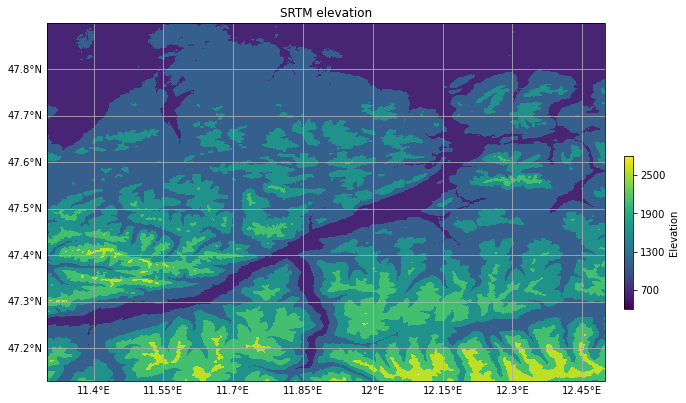

In [11]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

levels = np.arange(100, 3600, 600)
CS = ax.contourf(
    lons,
    lats,
    elevs,
    levels,
    transform=ccrs.PlateCarree())

# Here is how you can add your own points.
# ax.plot(sitex, sitey, transform=ccrs.PlateCarree(), marker='o', color='r')

# And here is how you could add a transect
# ax.plot(
#     [lons.min(), lons.max()],
#     [lats[site_ind_y], lats[site_ind_y]],
#     '--', color='xkcd:steel',
#     transform=ccrs.PlateCarree()
# )

# ax.plot(
#     [lons[site_ind_x], lons[site_ind_x]],
#     [lats.min(), lats.max()],
#     '--', color='xkcd:steel',
#     transform=ccrs.PlateCarree()
# )

# A custom colorbar builder
norm = matplotlib.colors.Normalize(vmin=CS.cvalues.min(), vmax=CS.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=CS.cmap)
sm.set_array([])
# Because cartopy automatically scales the figure size, using the axes transform
# for specifying the colorbar location can lead to non-intuitive results. Another
# method is to use the data transform. Similarly, the automatic colorbar from
# matplotlib is not useful unless the figure size is scaled to the final plot's
# aspect ratio.
rangey = maxy - miny
meany = np.mean((maxy, miny))
axins = inset_axes(
    ax, 
    width="100%",  # width = 25% of parent_bbox width
    height="100%",  # height : 5%
    bbox_to_anchor=(maxx + 0.05, meany - rangey / 4, 0.02, rangey / 2),
    bbox_transform=ax.transData)
cb = plt.colorbar(
    sm,
    cax=axins,
    # orientation="horizontal",
    ticks=levels)
cb.set_label('Elevation')

# plt.colorbar(CS)

ax.set_title('SRTM elevation')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.left_labels = True
gl.top_labels= False

## Google imagery

You will have to get the copyright information from maps.google.com or google earth using a similar view as the one presented here. Copyright cannot be retrieved remotely.

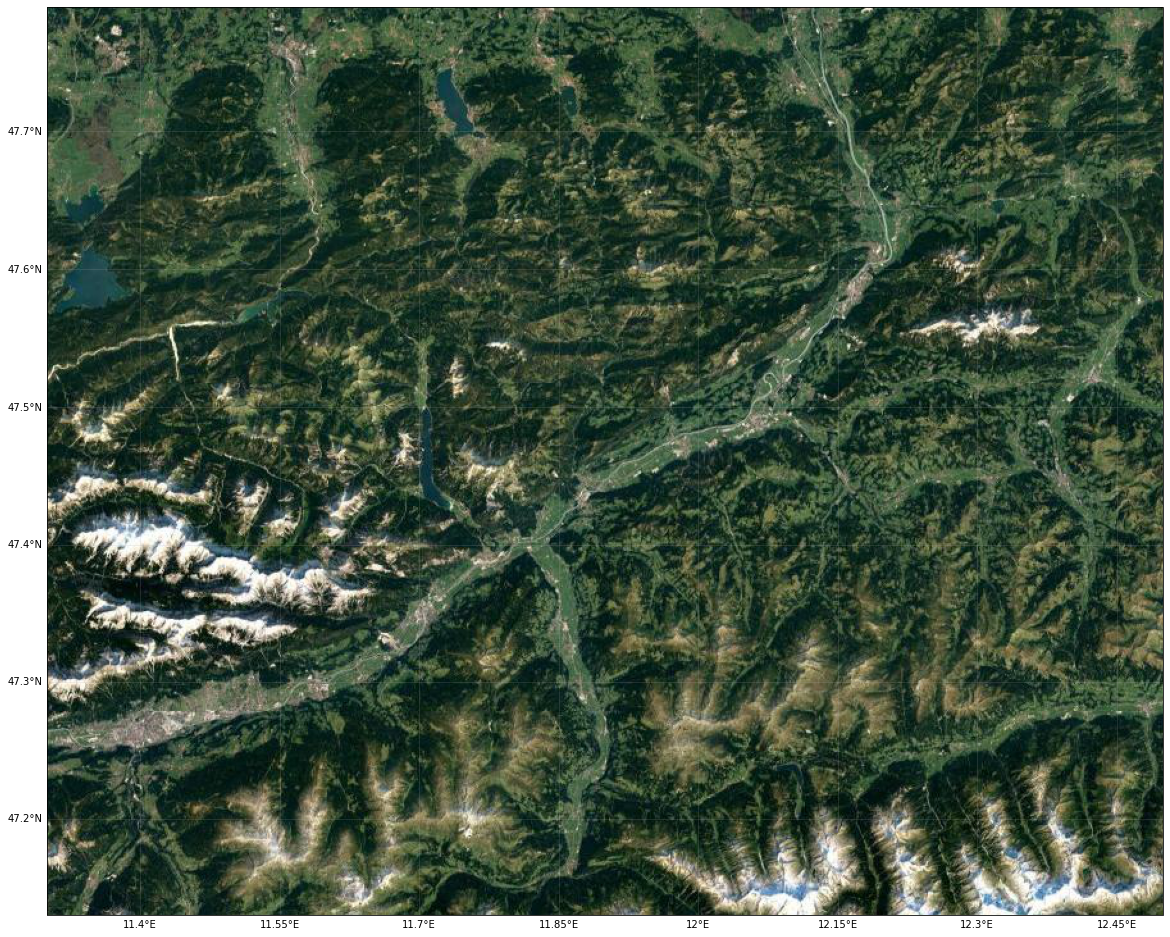

In [12]:
# Build the plot
request = cimgt.GoogleTiles(style='satellite')    

fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=request.crs)

# Google tiles
extent = [minx, maxx, miny, maxy]
ax.set_extent(extent)
# To adjust the image detail level change the zoom value. Larger means
# more zoomed out (coarser pixels).
zoom_level = 10
ax.add_image(request, zoom_level)

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels= False

## Combined google tiles and contours

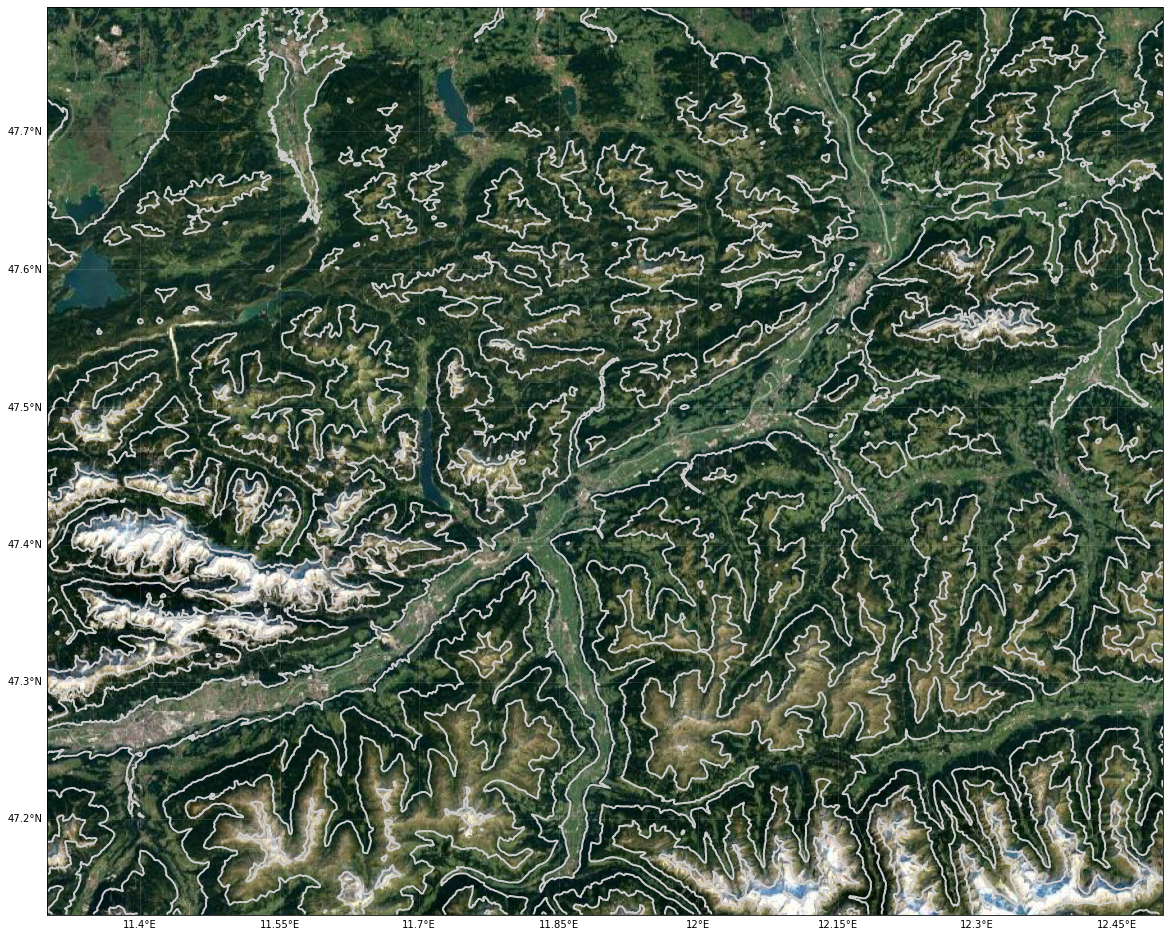

In [13]:
# Build the plot
request = cimgt.GoogleTiles(style='satellite')    

fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=request.crs)

# Google tiles
extent = [minx, maxx, miny, maxy]
ax.set_extent(extent)
ax.add_image(request, 10)

# Elevation contours
CS = ax.contour(
    lons,
    lats,
    elevs,
    np.arange(100, 3600, 600),
    transform=ccrs.PlateCarree(),
    # cmap='viridis_r',
    colors='0.8',
    linewidths=2,
)

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels= False

### Elevation transects

In [14]:
sitex = 11.62219
sitey = 47.305341

site_ind_x, site_ind_y = locate_site_index(sitex, sitey, lons, lats)

(47.13, 47.79)

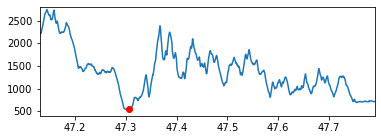

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(lats, np.ndarray.flatten(elevs[:, site_ind_x]))
ax.plot(sitey, elevs[site_ind_y, site_ind_x], 'ro')
ax.set_ylim(400, 2800)
ax.set_xlim(miny, maxy)

(11.3, 12.5)

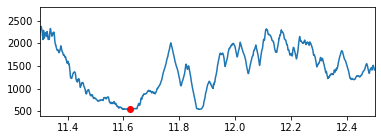

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))

ax.plot(lons, np.ndarray.flatten(elevs[site_ind_y, :]))
ax.plot(sitex, elevs[site_ind_y, site_ind_x], 'ro')
ax.set_ylim(400, 2800)
ax.set_xlim(minx, maxx)

## Everything together

This plot would need to be cleaned up, but it shows the general concept.

Text(0.1, 0.95, 'c)')

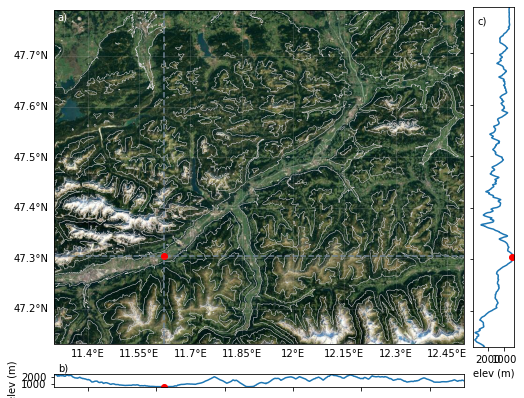

In [17]:

request = cimgt.GoogleTiles(style='satellite')



fig = plt.figure(figsize=(8.25, 7))
widths = [2, 0.2]
heights = [2, 0.08]
spec = fig.add_gridspec(ncols=2,
                        nrows=2,
                        width_ratios=widths,
                        height_ratios=heights,
                        hspace=0.15, wspace=0.04,
                        )
# Initiate all subplots
ax = fig.add_subplot(spec[0, 0], projection=request.crs)
bax = fig.add_subplot(spec[1, 0])
cax = fig.add_subplot(spec[0, 1])

# Google tiles
extent = [minx, maxx, miny, maxy]
ax.set_extent(extent)

# To adjust the image detail level change the zoom value. Larger means
# more zoomed out (coarser pixels).
zoom_level = 10
ax.add_image(request, zoom_level)

# Elevation contours
CS = ax.contour(
    lons,
    lats,
    elevs,
    np.arange(100, 3600, 600),
    transform=ccrs.PlateCarree(),
    colors='0.8',
    linewidths=0.5,
)

# Site location + transects for elevation profiles
ax.plot(
    [lons.min(), lons.max()],
    [lats[site_ind_y], lats[site_ind_y]],
    '--', color='xkcd:steel',
    transform=ccrs.PlateCarree()
)

ax.plot(
    [lons[site_ind_x], lons[site_ind_x]],
    [lats.min(), lats.max()],
    '--', color='xkcd:steel',
    transform=ccrs.PlateCarree()
)
ax.plot(sitex, sitey, transform=ccrs.PlateCarree(), marker='o', color='r')

# Gridlines and axes labels
ax.text(
    0.01, 0.97, 'a)',
    {'color':'w'},
    transform=ax.transAxes,
)
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels= False

# Profiles
bax.plot(lons, np.ndarray.flatten(elevs[site_ind_y, :]))
bax.plot(sitex, elevs[site_ind_y, site_ind_x], 'ro')
# bax.set_ylim(600, 700)
bax.set_xlim(minx, maxx)
bax.set_xticklabels('')
bax.set_ylabel('elev (m)')
bax.text(
    0.01, 1.2, 'b)',
    {'color':'k'},
    transform=bax.transAxes,
)


cax.plot(np.ndarray.flatten(elevs[:, site_ind_x]), lats)
cax.plot(elevs[site_ind_y, site_ind_x], sitey, 'ro')
cax.invert_xaxis()
# cax.set_xlim(1000, 600)
cax.set_ylim(miny, maxy)
cax.set_yticklabels('')
cax.set_xlabel('elev (m)')
# cax.set_xticks([600, 900])
cax.text(
    0.1, 0.95, 'c)',
    {'color':'k'},
    transform=cax.transAxes,
)

### Output the DEM as a netcdf to simplify future work

In [18]:
os.chdir(dir_data_maps)
ds_elev = xr.Dataset(
    {
        "elevation": (["lat", "lon"], elevs),
    },
    coords={
        "lon": (lons),
        "lat": (lats)
    }
)
ds_elev.attrs['projection'] = 'PlateCarree'
ds_elev.attrs['data_source'] = 'SRTM: N47E012.hgt + N47E011.hgt'
ds_elev.attrs['data_resolution'] = '1 arcsecond (~30m)'

ds_elev.to_netcdf('TEAMx-SRTM-elevation.nc')